# Learning Machines (Pt. 2): <div> Training a Neural Net

## Code Preamble

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import sys
sys.path.append('../py')

from plots import (
    set_grad_plot_fig_ax,
    set_grad_plot_styles,
    plot_activations,
    plot_function,
    plot_tangent_at_points,
    tangent_plot,
    plot_gradient_descent
    
)

## Resources

### Tutorials etc.

- Mirko Stojiljković: [Stochastic Gradient Descent Algorithm With Python and NumPy](https://realpython.com/gradient-descent-algorithm-python/). RealPython.
- [Machine Learning Glossary](https://ml-cheatsheet.readthedocs.io/)

### Textbooks

- I. Goodfellow, Y. Bengio & A. Courville (2016). [Deep Learning](https://www.deeplearningbook.org/). MIT Press.



## What We'll Learn Today

- A conceptual overview of neural networks
    - Forward pass
    - Backpropagation
- Mathematical fundamentals
    - Forward pass
        - Activation functions
    - Backpropagation
        - Derivatives
            - Intuition with simple functions
            - Gradient descent from scratch
        - The Chain Rule of Calculus
        - Overview: Chain rule for matrices

## Why?

- You'll save time! 
    - Intuition of the fundamentals makes it easier to work with applications
        - You don't have to be and expert on this or remember the math in detail
- It helps us cut through the nonsense and hype
    - Understand the practical techniques of power that surround us
- If you want: You will be able to start building your own models from scratch
    - Don't only rely on black-boxed techniques developed by other people

# Soooo... What is a Neural Network?

## High-level Overview

<center>
<div>
<img src="../img/neural_network_simple.png" width="50%"
     caption="test"/>
    <figcaption>The most simple possible neural network.</figcaption>
</div>
</center>

- **The GOAL:** Train our weights matrices $W_h$ and $W_O$ until they produce a good estimate of output $O$, given the input $X$
- A neural net can be thought of as a sequence of mathematical operations. We have an input, that we transform and then give as an output
- The way this transformation happens is iterative and includes three main steps:
    - Forward pass
        - Matrix multiplication
        - Addition of bias terms
        - Activation functions
    - Calculate difference between prediction and output
    - Backpropagation of the loss function 

- This first network would look like this: $(XW_h)W_o$
    - We start with input $X$ and multply it by a the first weights matrix $W_h$
        - This gives us our first "hidden layer" $H$, which is just $XW_h = H$
    - Then we multiply our hidden layer with our second weights matrix $W_o$ to get our output $O$
- This step of matrix multiplication is called the **forward pass**
- It is followed by **backpropagation**

### A More Complex Network (but still very simple)

<center>
<div>
<img src="../img/neural_network_w_matrices.png" width="50%"
     caption="test"/>
    <figcaption>This is still very simple, but our weights matrices have more dimensions.</figcaption>
</div>
</center>

Let's complicate things a bit. 

**PROMPT:** What is different with the network above, comparaed to the the previous slide?

- Mathematically the functions to represent the network is still $(XW_h)W_O$
    - It's just the dimensions of our weight matrices $W_H$ and $W_O$ as well as our output $O$ that have changed
    - When dimensions of one layer of the network change, the other layers need to be adapted. Let's see how

### Mathematical Ways of Thinking a Neural Net

- A sequence of matrices
- A set of nested functions
- These are the same thing! (in this context)

### Sequence of Matrices

<center>
<div>
<img src="../img/neural_network_matrices.png" width="50%"
     caption="test"/>
    <figcaption>A neural net can be thought of as a *sequence* of matrices. Each matrix multiplication transforms the network somehow.</figcaption>
</div>
</center>

Let's clarify that by looking at the network as a sequence of matrices instead.

**PROMPT**: $X$ has 4 rows and 2 columns. $W_H$ has 2 rows and 3 columns. What size matrix do we get when we multiply them?

- We get $H$, which has 4 rows like $X$, and 3 columns like $W_H$, just as the rules of matrix multiplication would tell us.
- Each matrix transforms the data, just like a function would do...

**PROMPT:** What do the rows and columns in $X$ represent?

- The rows of $X$ are observations. We'll see this in the next lecture when we build a neural net from scratch
- The columns of $X$ are "features", attributes of each observation that we use to classify or understand them

**PROMPT:** What do the rows and columns in $O$ represent?

### Nested Functions

<center>
<div>
<img src="../img/chain_rule-dolls.gif" width="50%"
     caption="test"/>
    <figcaption>A neural net can be thought of as a set of nested dolls. Each doll is another function and each function a layer.</figcaption>
</div>
</center>

- Before we move forward, let's conjure one more image to think of neural nets
- Neural nets can also be thought of as nested functions
    - Indeed, [matrices are essentially functions](https://mbernste.github.io/posts/matrices_as_functions/), i.e. transformations on some input $x$ that produce an output $y$
    - This analogy is useful once we try to understand how the Chain Rule of Calculus applies to neural nets

## Forward pass

- Okay, we've covered the principles of neural nets on a very high level
- Main components:
    - Matrix multiplication
    - Bias terms
    - Activation functions

### Matrix Multiplication

**Names:** Matrix multiplication, matrix product, Dot product (for vectors, but used more widely) <br>
**Python:** ```@``` <br>
**NumPy:**```np.dot``` <br>
**Torch**: ```torch.matmul``` <br>
**Input**: ```n x m``` and ```m x k``` matrices <br>
**Output:** ```n x k``` matrix


<center>
<div>
<img src="../img/neural_network_matrices.png" width="50%"
     caption="test"/>
</div>
</center>

In this example, we **START** with three objects: 

1. Our initial observations in the matrix X. 
- $x_1$ and $x_2$ stand for features of the data. 
- It is in $\mathbb{R}^{4 \times 2}$

2. The first set of weghts in the matrix $W_H$
- We initialize it with random values
- It is in $\mathbb{R}^{2 \times 3}$

3. The second set of weights in the matrix $W_O$
- We initialize it with random values
- It is in $\mathbb{R}^{2 \times 3}$

We want to **PRODUCE**:
    
1. Our hidden layer $H$
- This object is created during the first pass of the network
- It is in $\mathbb{R}^{4 \times 3}$

2. Our outputs $O$
- This is the product of all our matrix multiplications
- It is in $\mathbb{R}^{4 \times 2}$, just like $X$
    - In this example we are trying to estimate some features of our observations $x_i$

Let's initialize the input and the weights:

In [12]:
X = np.array([[1,0],[0,1], [1,1], [0,0]])
W_H = np.random.rand(2,3)
W_O = np.random.rand(3,2)

W_O

array([[0.8601045 , 0.59958437],
       [0.1089713 , 0.35396821],
       [0.15322936, 0.05884676]])

**PROMPT:** What are the dimensions of H? How would you produce this matrix?

In [13]:
H = X @ W_H
H.shape

(4, 3)

**PROMPT:** What are the dimensions of $O$? What's notable about these dimensions?

In [16]:
O = H @ W_O
O.shape

(4, 2)

**PROMPT:** Why is the last row of values in $O$ all zeroes?

In [17]:
O

array([[0.2803073 , 0.34938754],
       [0.55506881, 0.61553694],
       [0.83537611, 0.96492448],
       [0.        , 0.        ]])

### Bias terms

- In linear regression, if we take $y = ax + b$, the line will go through the origin.
    - The same is true for the weights of a neural network 
- If we have data that isn't centered around zero, we might want to *shift* it using a **bias term**
- Bias terms typically accompany weights and must also be learned by your model

<center>
<div>
<img src="../img/nn_with_matrices_and_activations.png" width="80%"
     caption="test"/>
    <figcaption>A neural net can be thought of as a set of nested dolls. Each doll is another function and each function a layer.</figcaption>
</div>
</center>

In [27]:
H.shape

(4, 3)

In [28]:
b1 = np.full((4, 3), 1)
b1

array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]])

In [29]:
H = X @ W_H + b1
H

array([[1.11514961, 1.67516462, 1.70282244],
       [1.45573885, 1.89597707, 1.42713742],
       [1.57088846, 2.57114169, 2.12995986],
       [1.        , 1.        , 1.        ]])

In [30]:
H.shape

(4, 3)

In [31]:
b2 = np.full((4, 2), -1)
b2

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [32]:
O = H @ W_O + b2
O

array([[0.40261245, 0.36178688],
       [0.67737397, 0.62793628],
       [0.95768127, 0.97732382],
       [0.12230516, 0.01239934]])

### Activation Functions

<center>
<div>
<img src="../img/nn_with_matrices_and_activations.png" width="80%"
     caption="test"/>
    <figcaption>A neural net can be thought of as a set of nested dolls. Each doll is another function and each function a layer.</figcaption>
</div>
</center>

- Functions which wrap the hidden layers and output
    - Basically says which neurons should fire
- Produce simple outputs, which stacked produces complex behavior

### Properties

- **Non-linear:** In linear regression we’re limited to a prediction equation that looks like a straight line. 
    - Nice for simple datasets with a one-to-one relationship between inputs and outputs
    - *But*: What if the patterns in our dataset were non-linear? (e.g. $x^2$, $\sin$, $\log$). 
        - To model these relationships we need a non-linear prediction equation.
    - Activation functions provide this non-linearity.
- **Continuously differentiable:** To improve our model with gradient descent, we need our output to have a nice slope so we can compute error derivatives with respect to weights. 
    - If our neuron instead outputted 0 or 1 (original perceptron), we wouldn’t know in which direction to update our weights to reduce our error.
- **Fixed Range:** Activation functions typically squash the input data into a narrow range that makes training the model more stable and efficient.
    - E.g.: Sigmoid and softmax produce 0 to 1 probabilities

In [33]:
def sigmoid(x):
    ''' It returns 1/(1+exp(-x)). where the values lies between zero and one '''
    return 1/(1+np.exp(-x))

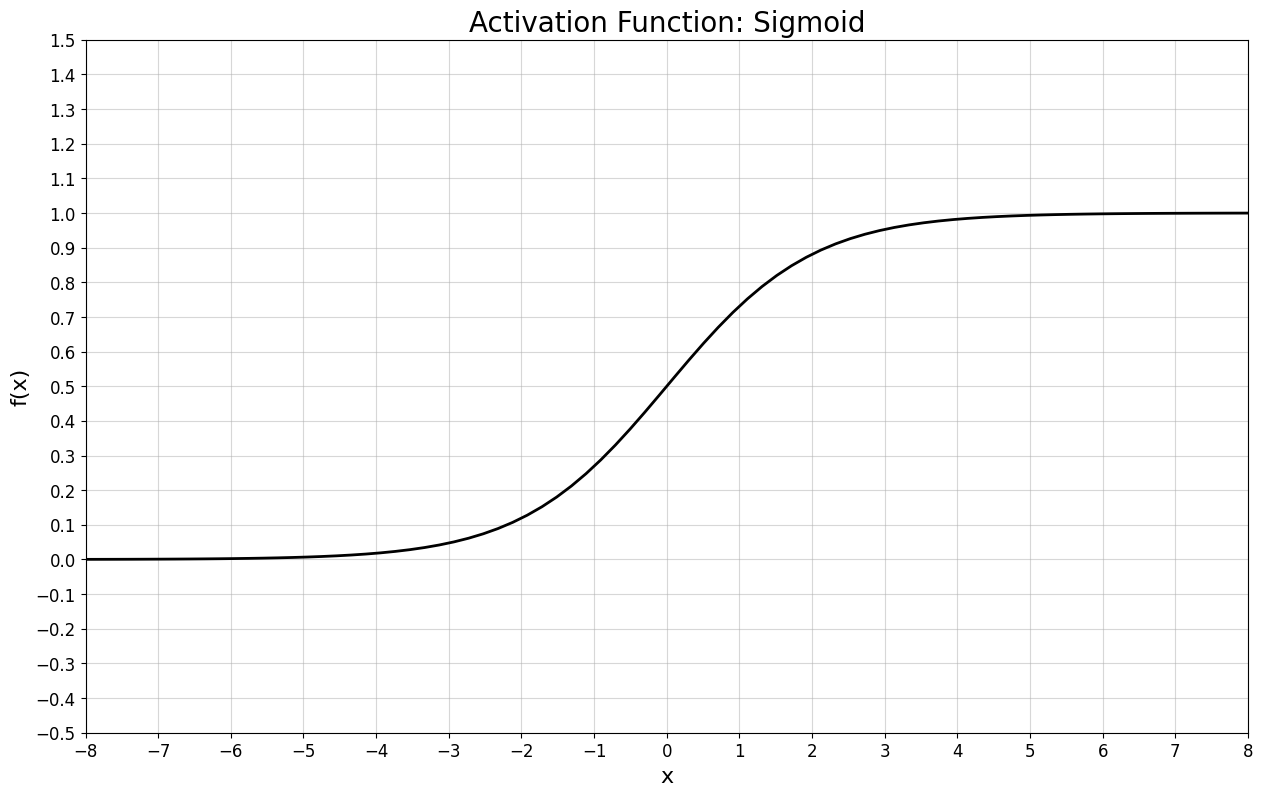

In [34]:
x = np.linspace(-10, 10, 100)

plot_function(x, sigmoid(x), [-8,8], [-.5, 1.5], 'Activation Function: Sigmoid')

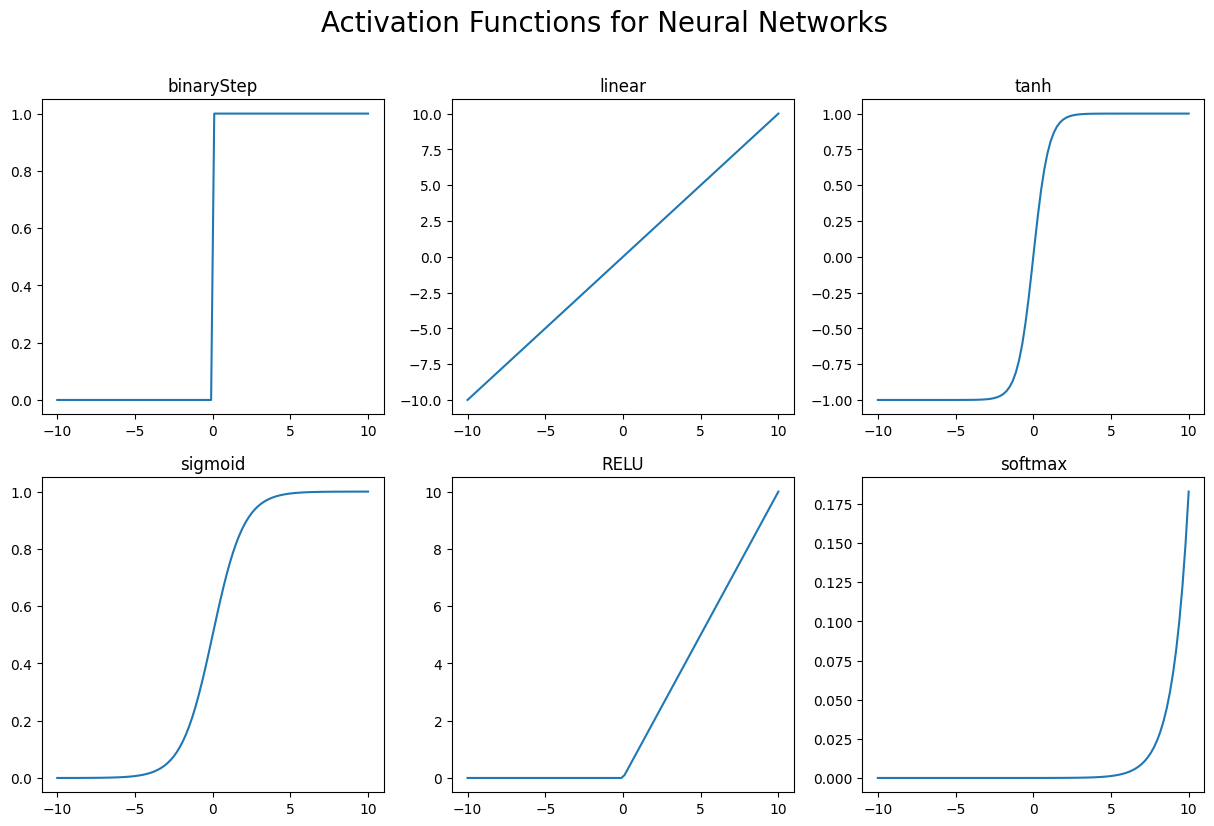

In [35]:
plot_activations(x)

**PROMPT:** Try to code the following actication functions in Python:
        
1. binaryStep
2. linear
3. RELU

In [159]:
def binaryStep(x):
    ''' It returns '0' is the input is less then zero otherwise it returns one '''
    return np.heaviside(x,1)

In [160]:
def linear(x):
    ''' y = f(x) It returns the input as it is'''
    return x

In [39]:
def RELU(x):
    ''' It returns zero if the input is less than zero otherwise it returns the given input. '''
    return x * (x > 0)

In [36]:
def softmax(x):
    ''' Compute softmax values for each sets of scores in x. '''
    calc = np.exp(x) / np.sum(np.exp(x), axis=0)
    return calc

In [163]:
def tanh(x):
    ''' It returns the value (1-exp(-2x))/(1+exp(-2x)) and the value returned will be lies in between -1 to 1.'''
    return np.tanh(x)

**PROMPT:** What kind of outputs do you get if you apply all the different activation functions to $H$?

In [37]:
sigmoid(H)

array([[0.75308791, 0.84226319, 0.845903  ],
       [0.81088008, 0.86943553, 0.8064549 ],
       [0.82791023, 0.92898106, 0.8937812 ],
       [0.73105858, 0.73105858, 0.73105858]])

In [40]:
RELU(H)

array([[1.11514961, 1.67516462, 1.70282244],
       [1.45573885, 1.89597707, 1.42713742],
       [1.57088846, 2.57114169, 2.12995986],
       [1.        , 1.        , 1.        ]])

#### Sigmoid & Softmax

- The sigmoid function takes an input with two classes (like vectors encoding a coin toss) and "squeezes" these into a probablity
- The softmax does the same for multilabel data
    - These are the most common activation functions for the final layer of classifiers
        - Most of NLP is classification, even language modelling

**1. Sigmoid**
- The sigmoid function is defined as:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

- Note that we only need to input some $x$, because the probability distribution is over just two events
    - When we get the sigmoid $\sigma(\text{heads})$ for "heads", "tails" is just: $\sigma(\text{tails}) = 1 - \sigma(\text{heads})$


**2. Softmax**
- Now we have a multinomial distribution of possible events
- We have to go over each element $z_i$ in the vector $Z$ of length $K$
    - The softmax value is achieved by applying exponentiating $e$ by each value and then normalizing by taking their sum.

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_j^K e^{z_j}}
$$

## Loss & Backpropagation

- **Goal:** Adjust each weight in the network in proportion to how much it contributes to overall error.
    - Calculate the loss
    - It's just a bunch of calculus
- Main components:
    - Loss function
    - Derivative of the loss function
- If $X$ is our input and our cross-entropy loss function is $L_{CE}$, then:
    
$$
\frac{\partial L_{CE}}{\partial X}
$$

### Loss function

- Usually cross-entropy, can be many others too:
    - Mean Square Error (MSE), Mean Absolute Error (MAE), Kullback-Leibler ($\mathbb{KL}$)
- Cross-entropy
    - Calculates the cost of encoding our data with the probabilities of our model
    - We'll write it without the bias terms to make things a bit clearer
    - We often take the log loss, because it is mathematically easier to operate with
        - So the log of cross-entropy
    - We've not looked at that, so let's stick the function we are familiar with from before

$$
\begin{equation}
    \begin{aligned}
    \text{Loss} &= L_{CE}(Q) \\ 
    &= L_{CE}(\sigma((W_OH)) \\
    &= L_{CE}(\sigma(W_O(XW_H))))
    \end{aligned}
\end{equation}
$$

$$
\text{Loss} = -\sum_i^K y_i \log L_{CE_i}
$$

$$
\text{Loss} = -\sum_i^K y_i \log (\sigma(W_O(XW_H))))
$$

### Gradient

- In order to make the network "learn", we take the derivative of the loss for all the different variables that make it up
- But this is a hard function to differentiate! 
    - We *could* differentiate it, but we won't
    - Instead we'll work with toy examples to build intuition
    - Modern frameworks for neural nets like PyTorch, JAX and TensorFlow automate the calculation of the gradient

### Backprop

- Then we "propagate" the derivatives backwards
    - Correct each matrix in the **direction** of the derivative and by the **magnitude** of some value
        - This value is the **learning rate**, usually a very small fraction

## REPEAT!

- Then we repeat everything
- The number of times we repeat is decided by the number of **epochs** in our loop
    - For each epoch we go over the entire data in pieces known as **"batches"**

## Aside: The Derivative

The [two (most common) ways to write the derivative](https://www.khanacademy.org/math/ap-calculus-ab/ab-differentiation-1-new/ab-2-1/a/derivative-notation-review) are:

- Lagrange's notation: $f'(x)$
- Leibniz's notation: $\frac{df}{dx}$

The former is maybe easier, but the latter is important once we start evaluating more complex derivatives for actual neural networks. We'll stick to Lagrange's notation through the first half of this lecture, then hop to Leibniz's notation.

**PROMPT:** What is the general rule for taking derivatives of a polynomial like $x^n$

If $f(x) = x^n$, then

$$
f'(x) = \frac{df}{dx} = nx^{n-1}
$$

In [41]:
# objective function
def f_polynomial(x):
    f_x = x**2.0
    return f_x
 
# derivative of objective function
def f_polynomial_gradient(x):
    return x * 2.0

In [43]:
xs = np.linspace(-5, 5, 1000)
ys = f_polynomial(xs)

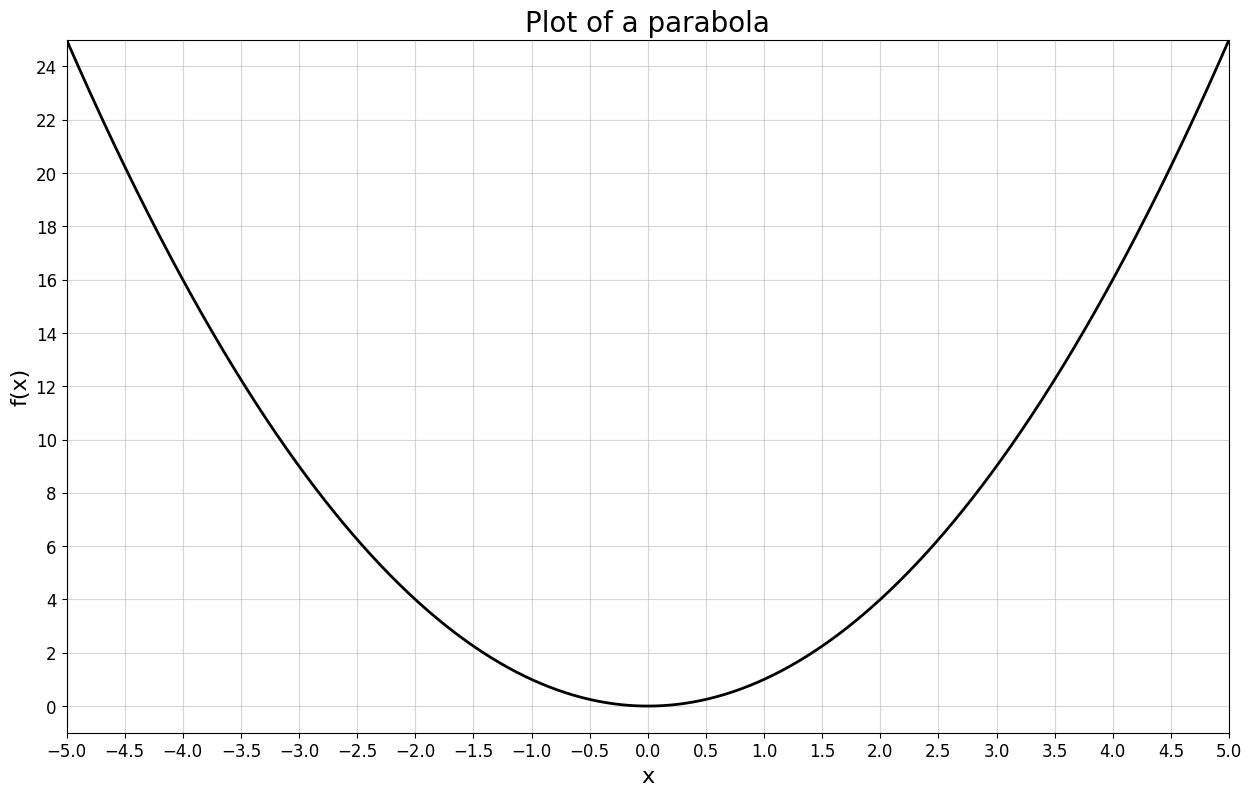

In [44]:
plot_function(xs, ys, [-5,5], [-1,25], 'Plot of a parabola')
plt.show()

$$
\begin{equation}
f(x) = x^2 \\
f'(x) = 2x \\
\end{equation}
$$

**PROMPT:** What's the minima of this function?

To find the minima, we set the derivative to zero and solve:

$$
2x = 0 \\
x = 0
$$

&rarr; Our minima is when $x$ is zero

In [45]:
x_gradients = np.linspace(-5, 5, 1000)
y_gradients = f_polynomial_gradient(x_gradients)

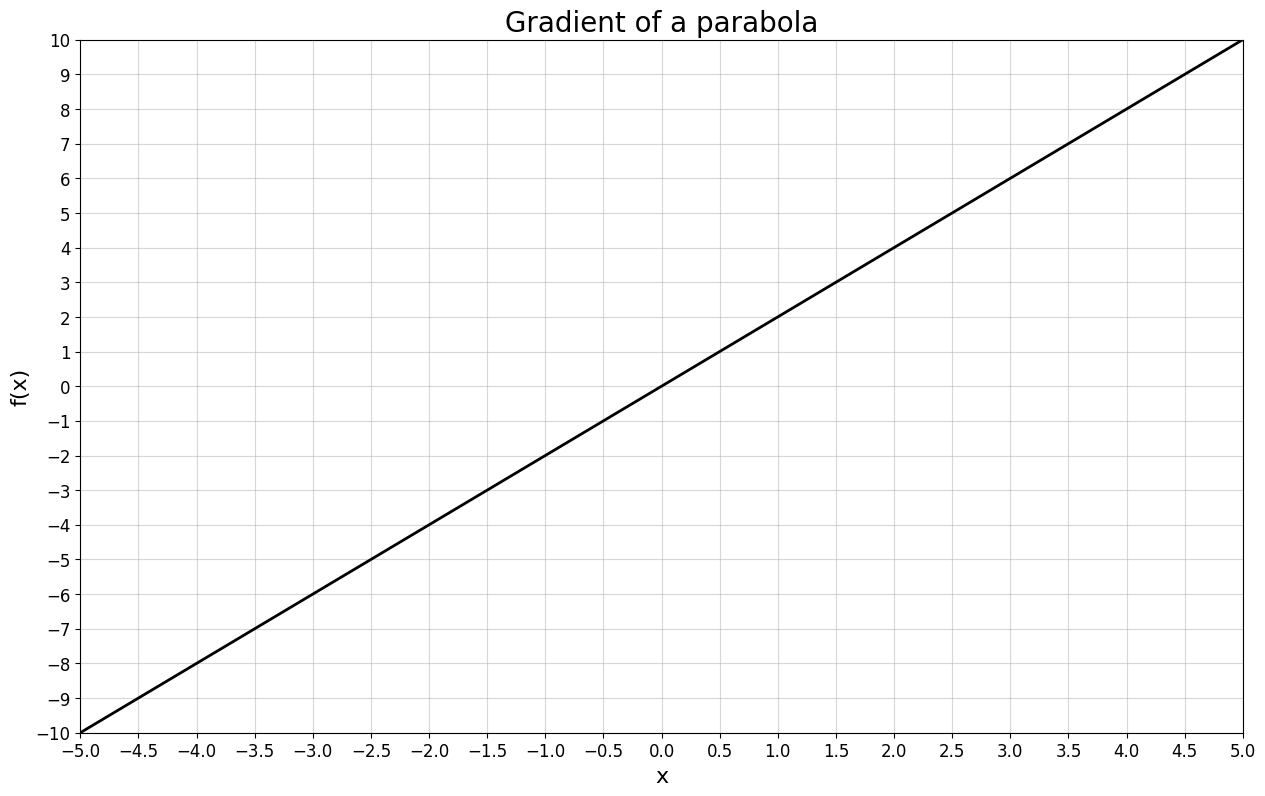

In [46]:
plot_function(x_gradients, y_gradients, [-5,5], [-10,10], 'Gradient of a parabola')

## Backprop: Gradient Descent

- Above we have derived the gradient analytically
- We **know** where the parabola has its minima
- But sometimes we don't have this information
    - The gradient can be some very complex function over many dimensions
    - Instead of analytically solving the gradient for minima, we evaluate it at specific points, like in the interactive plot above
- What we need:
    - An objective function
    - The derivative of the objective function

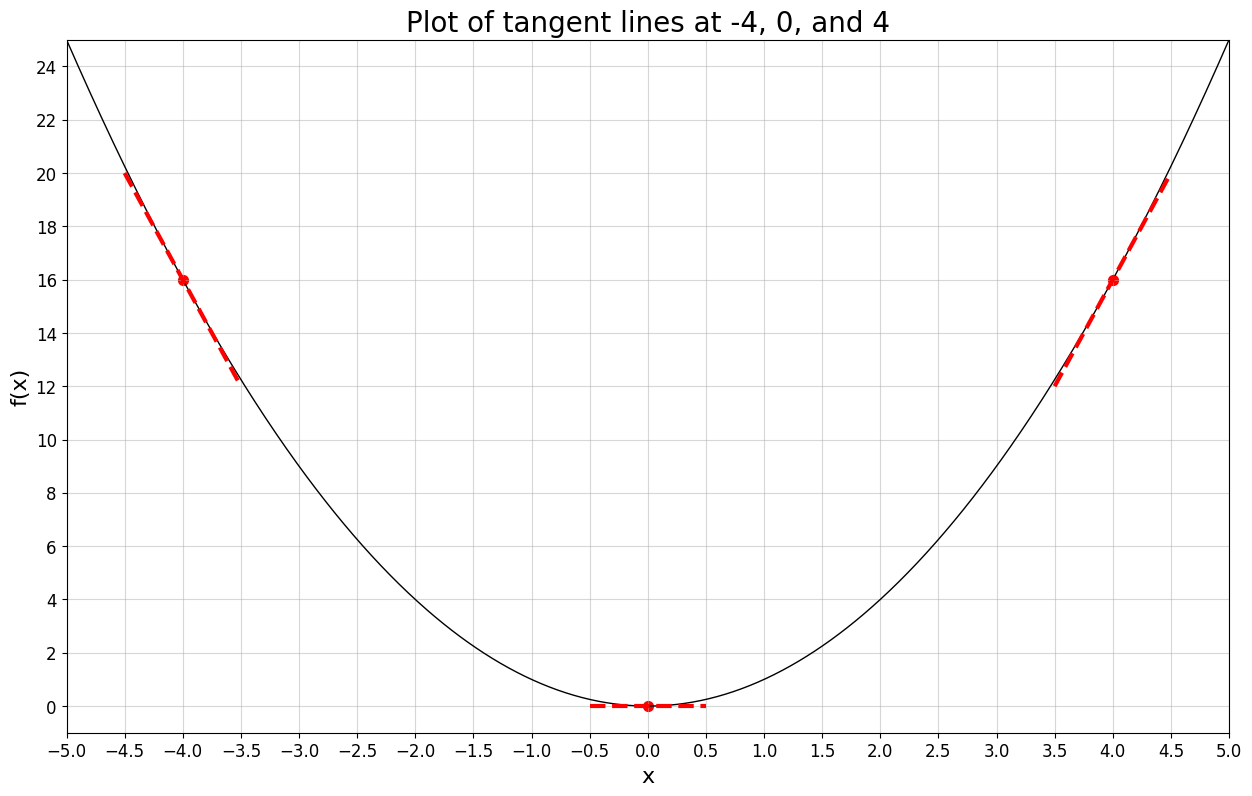

In [47]:
plot_tangent_at_points(xs, ys, f_polynomial,f_polynomial_gradient,[-4, 0, 4])

In [48]:
import ipywidgets as widgets

from ipywidgets import interactive

In [52]:
interactive_tangent = interactive(tangent_plot, x1 = (-10,10), step = 100)
interactive_tangent

interactive(children=(IntSlider(value=0, description='x1', max=10, min=-10), Output()), _dom_classes=('widget-…

So how do we create this movement? Like this:
1. We pick a random point $a$ for $x$
2. We evaluate the derivative of our objective function at this point
    - I.e we take $f'(a)$
3. Now, one of two things can happen:
    - The derivative is positive, i.e. $f'(x) > 0$: We move up
    - The derivative is negative, i.e. $f'(x) < 0$: We move down
        - The size of the above steps is determined by the **learning rate** multiplied with $f'(a)$
4. Repeat for $n$ **epochs** OR until $f'(x) = 0$

**PROMPT:** Code the above function for ```f_polynomial``` <div>
**Hint 1:** You will need to use ```f_polynomial_gradient``` inside a for-loop <div>
**Hint 2:** You will need to set:
1. A random starting point
2. The learning rate
3. The number of epochs

Okay, here is a version of the function:

In [174]:
def gradient_descent_simple(gradient_function, start, learn_rate, n_iter):
    gradient_vector = start
    for _ in range(n_iter):
        diff = -learn_rate * gradient_function(gradient_vector)
        gradient_vector += diff
    return gradient_vector

We know it works if it will be able to approximate that the minima of $x^2$ is $0$. And it does:

In [175]:
gradient = gradient_descent_simple(
    gradient_function=f_polynomial_gradient,
    start=start,
    learn_rate=lr,
    n_iter=50)

np.round(gradient, 0)

-0.0

Okay, to understand the internal workings of this approach, we will now use a more complicated function. We want to track how the algorithm moves through both $f(x)$ and $f'(x)$ over our epochs. We will also add a new variable, "tolerance". If our gradient steps fall below this very small value, we stop the algorithm.

In [176]:
def gradient_descent(
    objective, gradient, start, learn_rate, n_epochs=50, tolerance=1e-06, print_epochs=False):
    vector = [start]
    evals = []
    eval_ =  objective(start)
    if print_epochs:
        print(f'Start: f({start}) = {round(eval_,20)}')
    evals.append(eval_)
    for idx, _ in enumerate(range(n_epochs)):
        diff = -learn_rate * gradient(vector[idx])
        if np.all(np.abs(diff) <= tolerance):
            break
        current = vector[idx] + diff
        eval_ =  objective(current)
        if print_epochs:
            print(f'Epoch {idx}: f({current}) = {round(eval_,20)}')
        vector.append(current)
        evals.append(eval_)
    return vector, evals

In [177]:
lr = 0.2
start = 10.0
n_epochs = 50

gradients, evals = gradient_descent(
    objective=f_polynomial,
    gradient=f_polynomial_gradient,
    start=start,
    learn_rate=lr,
    n_epochs=n_epochs
)

We will draw $x^2$ from -10.5 to 10.5

In [178]:
parabola_x = np.linspace(-10.5,10.5,1000)

And now we can see how the algorithm works. 

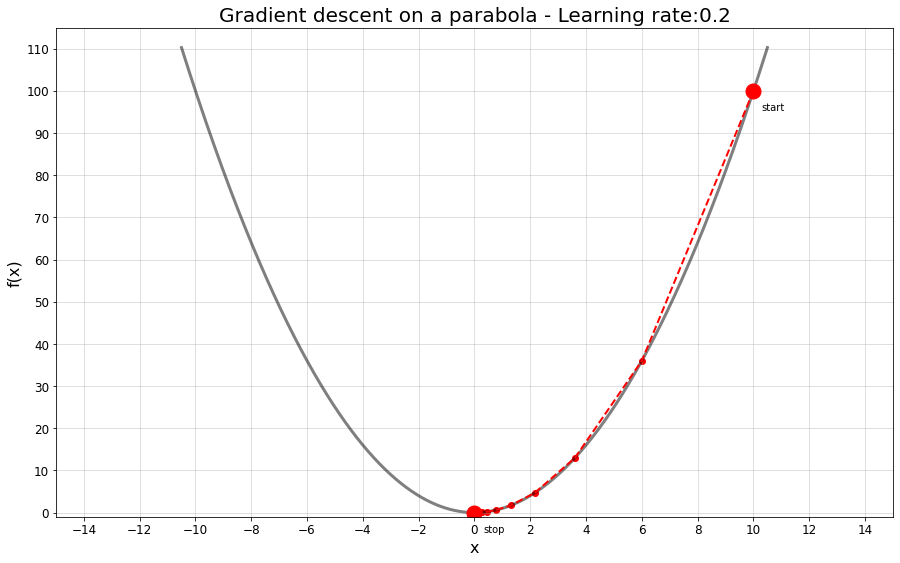

In [179]:
plot_gradient_descent(gradients, f_polynomial, parabola_x, 
                      ylim=[-1, 115], xlim=[-15, 15],
                      title=f'Gradient descent on a parabola - Learning rate:{lr}')

Our algorithm starts at $10$, our chosen random starting value. Then it takes a HUGE step. 

**PROMPT:** Why?

Well, because:

$$
f'(10) = 2 \times 10 = 20
$$

We then multiply that by our learning rate to get the step size:

$$
\text{step size} = 20 \times 0.2 = 4
$$

Now we subtract this from our initial value and start over. So, since $10 - 4 = 6$, we start at $6$:

$$
f'(6) = 2 \times 6 = 12 \\
\text{step size} = 12 \times 0.2 = 2.4
$$

Now the next steps starts at $3.6$...

And so on... for $50$ epochs OR until the step size is zero.

If we look at our list of gradients, we see that this is indeed what's going on. We start at $10$, move to $6$, then to $3.6$...

In [180]:
np.round(gradients[:3], 2)

array([10. ,  6. ,  3.6])

### Learning Rate & Epochs

Let's now take a closer look at our learning rate and epochs. It seems like they should matter quite a bit for how the algorithm performs. Let's first set our learning rate to 0.8, much higher than before. For instance, our first step would now be $16$ instead of $4$, throwing us from $x=10$ all the way to $x=-6$.

In [181]:
lr = 0.8
start = 10.0

gradients, evals = gradient_descent(
    objective=f_polynomial,
    gradient=f_polynomial_gradient,
    start=start,
    learn_rate=lr,
    n_epochs=n_epochs
)

And yeah, that's indeed quite a jump! If we were working with a more unusual objective function, these kinds of erratic movements could take us all kinds of weird places. We want the learning process to be *smooth*.

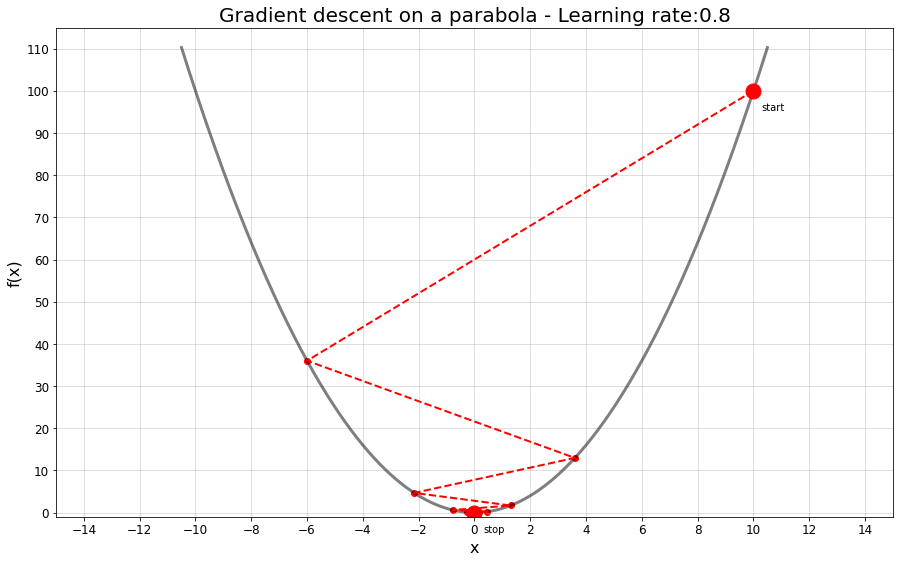

In [182]:
plot_gradient_descent(gradients, f_polynomial, parabola_x, 
                      ylim=[-1, 115], xlim=[-15, 15],
                      title=f'Gradient descent on a parabola - Learning rate:{lr}')

What happens if we instead lower the learning rate?

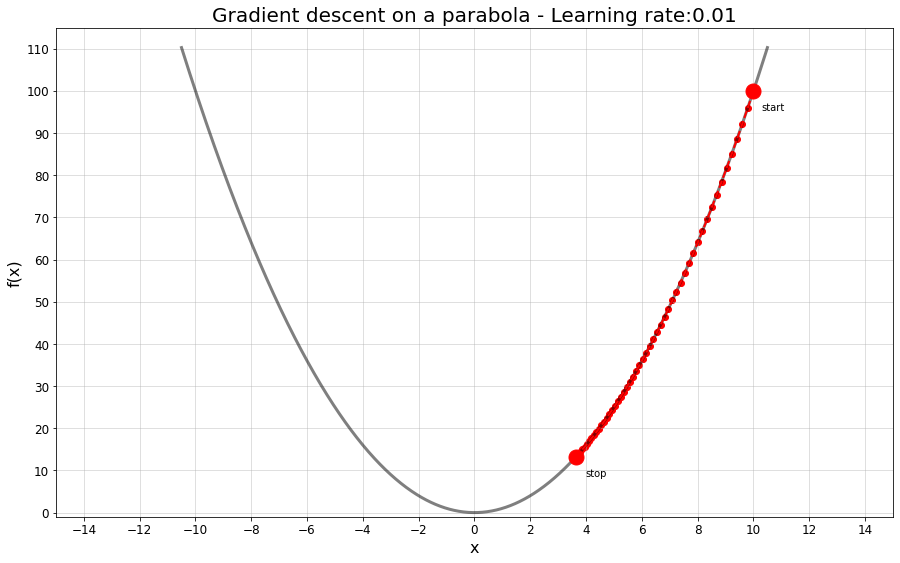

In [183]:
lr = 0.01
start = 10.0

gradients, evals = gradient_descent(
    objective=f_polynomial,
    gradient=f_polynomial_gradient,
    start=start,
    learn_rate=lr
)

plot_gradient_descent(gradients, f_polynomial, parabola_x, 
                      ylim=[-1, 115], xlim=[-15, 15],
                     title=f'Gradient descent on a parabola - Learning rate:{lr}')

We don't even get to the minima!

We can get there by iterating over more epochs, but we have to go about as high as $200$. That will be computationally much more costy than working with a good learning rate.

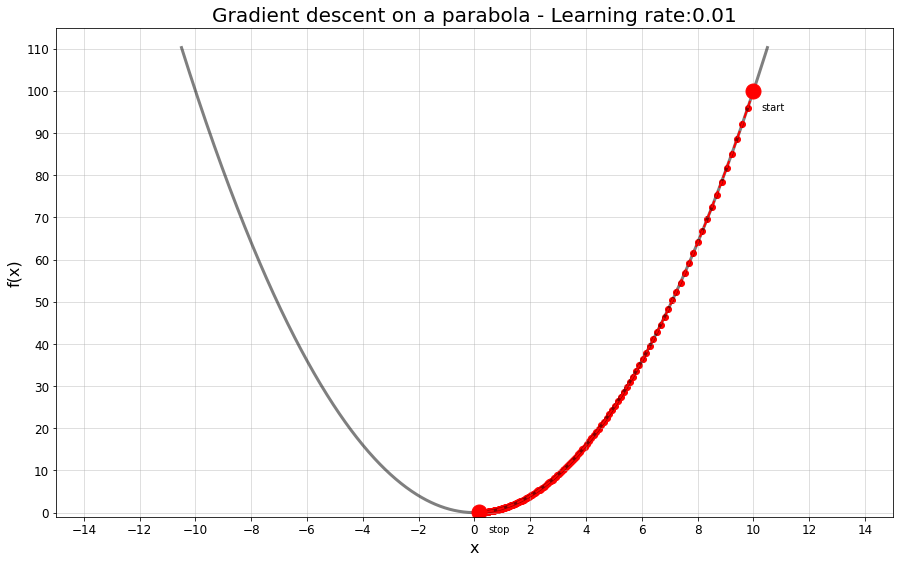

In [184]:
lr = 0.01
start = 10.0
epochs = 100

gradients, evals = gradient_descent(
    objective=f_polynomial,
    gradient=f_polynomial_gradient,
    start=start,
    learn_rate=lr,
    n_epochs = 200
)

plot_gradient_descent(gradients, f_polynomial, parabola_x, 
                      ylim=[-1, 115], xlim=[-15, 15],
                     title=f'Gradient descent on a parabola - Learning rate:{lr}')

### Local Min & Max, Saddle Points

So far we've been playing with a very simple objective function ($x^2$) with a very simple gradient function ($2x$). To understand what kind of issues might arrise with an actual objective function like cross-entropy or mean squared errors, we should plot something a tiny bit more complicated. Let's go over two examples.

First, let's see what kind of gradient we get for $-x^3$.

**PROMPT:** What is the derivative of $-x^3$?

The derivative we need is $-3x^2$.

**PROMPT:** Now, write the functions ```f_third_order```and ```f_third_order_gradient``` for the objective function and it's derivative, respectively.

In [185]:
def f_third_order(x):
    return -x**3

def f_third_order_gradient(x):
    return -3*x**2

Seems to work fine...

In [186]:
f_third_order(4)

-64

In [187]:
f_third_order_gradient(4)

-48

**PROMPT:** Run gradient descent with these functions. Use ```lr=0.1```and start at ```-2```. What kind of problem do you notice? What happens when you change the ```lr```and start values?

In [188]:
start = -2
lr = 0.1

gradients, evals = gradient_descent(
    objective=f_third_order,
    gradient=f_third_order_gradient,
    start=start,
    learn_rate=lr
)

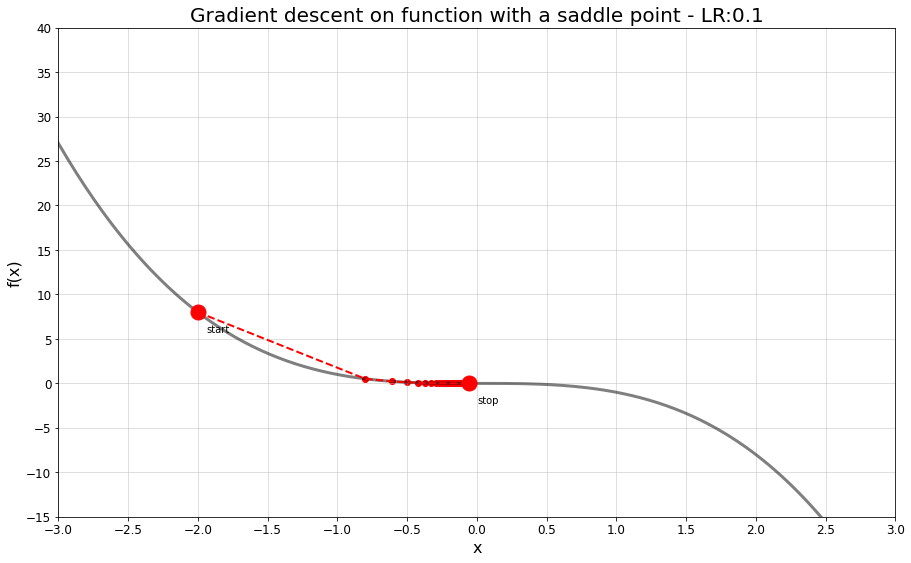

In [189]:
plot_gradient_descent(gradients, f_third_order,
                      parabola_x, ylim=[-15, 40], xlim=[-3, 3],
                      title=f'Gradient descent on function with a saddle point - LR:{lr}')

So, indeed, there is an issue: The function clearly isn't at it's minima, but our algorithm has stopped. Why?

**PROMPT:** Now, what is the minima of $-x^3$

If we set the derivative to zero and solve, we get:
    
$$
-3x^2 = 0 \\
x = \sqrt(0) \\
x = 0
$$

But is this a minima? No, it's not.

**PROMPT:** Why?

Well, to find out if a function is *actually* at it's minima, we would have to see whether the derivatives at points right before and after zero are of opposite signs (indicating the slope of the function first rises and falls, or vice versa). This is not the case here. A sloppy demonstration:

$$
-3 (1)^2 = -3
$$

$$
-3 (-1)^2 = -3
$$

**PROMPT:** Why did our algorithm get stuck around $x=0$?

Well, because the derivative also evaluates to zero here:

$$
f'(x) = -3x^2 \\
f'(0) = -3 \times0^2
$$

We get stuck at a [**saddle point**](https://en.wikipedia.org/wiki/Saddle_point): An inflection point where the derivative is first negative, then zero, then negative again.

And there are other types of pitfalls (literally!). Let's explore another function to see what:

$$
f(x) = x^4 - 5x^2 - 3x
$$

**PROMPT:** What is the derivative of this function?

$$
f'(x) = 4x^3 - 10x - 3
$$

In [190]:
def f_higher_polynomial(x):
    return x**4 - 5*(x**2) - 3*x

def f_higher_polynomial_gradient(x):
    return 4*(x**3) - 10*x - 3

Now let's plot that.

In [191]:
start = -2
lr = 0.2

gradients, evals = gradient_descent(
    objective=f_higher_polynomial,
    gradient=f_higher_polynomial_gradient,
    start=0.0,
    learn_rate=0.2
)

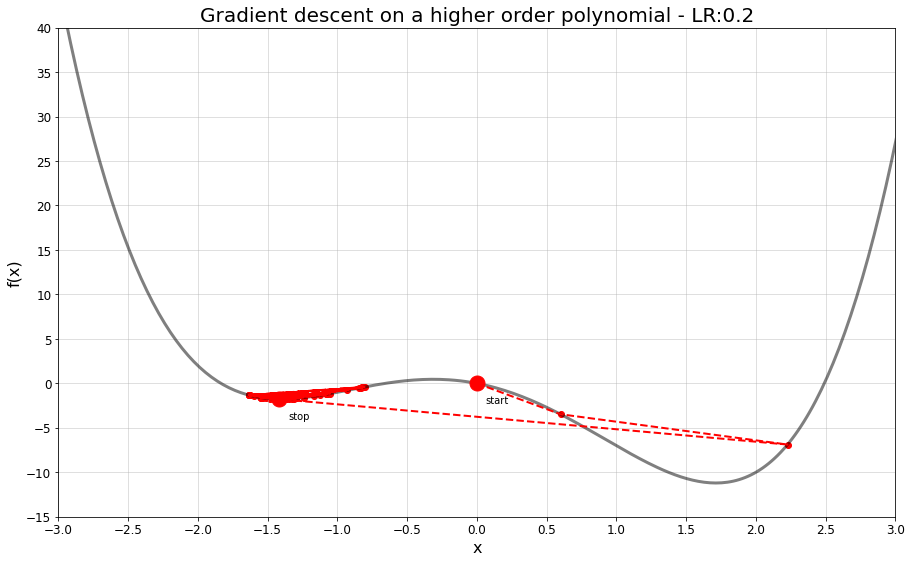

In [192]:
plot_gradient_descent(gradients, f_higher_polynomial,
                      parabola_x, 
                      ylim=[-15, 40], xlim=[-3, 3],
                      title=f'Gradient descent on a higher order polynomial - LR:{lr}')

Uh-oh, more trouble! 

**PROMPT:** What't the problem here?

We've hit a **local minima**, but not *the* **global minima** of the function! Complex functions will often, in addition to a global minima and maxima, also have:

- Local minima
- Local maxima
- Saddle points

<center>
<div>
<img src="../img/DL_book_min_max_saddle.png" width="80%"
     caption="test"/>
    <figcaption>Source: Goodfellow et al. 2016</figcaption>
</div>
</center>

There are different tricks for getting past these, indeed entire fields of inquiry dedicated to these problems. A common trick is, like above, to fiddle with the learning rate. Turns out that does the trick here:

In [193]:
start = 0.0
lr = 0.1

gradients, evals = gradient_descent(
    objective=f_higher_polynomial,
    gradient=f_higher_polynomial_gradient,
    start=start,
    learn_rate=lr
)

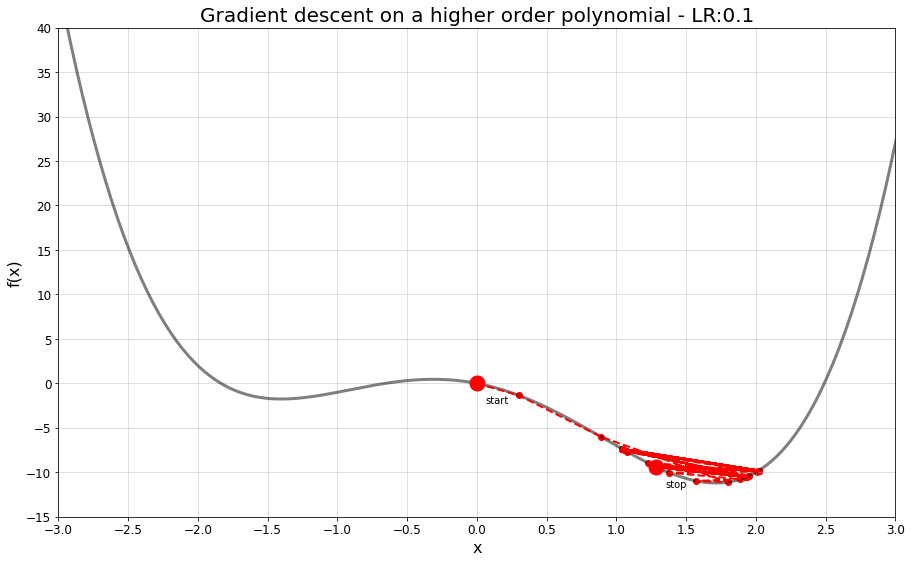

In [194]:
plot_gradient_descent(gradients, f_higher_polynomial,
                      parabola_x, ylim=[-15, 40], xlim=[-3, 3],
                      title=f'Gradient descent on a higher order polynomial - LR:{lr}')

## Backprop: The Chain Rule

So far we've dealt with functions that are very simple. Yes, maybe the polynomial is higher order, but we can just apply the rule that $f'(x) = nx^{x-n}$. Most derivatives in a neural net are not so simple! Let's take an example. How would we differentiate this function?

$$
f(x) = (2x - 3)^4 
$$

We will need to use the **chain rule**. Before we define it, let's build some intuition. This is in fact a **composite function.** If

$$
g(x) = 2x - 3
$$

then

$$
f(x) = f(g(x))
$$

We can continue this logic. In fact, composite functions are often compared to nested Matryoshka dolls.

<center>
<div>
<img src="../img/chain_rule-dolls.gif" width="50%"
     caption="test"/>
    <figcaption>The Chain Rule is like a (friendly! not scary) nested doll: You take the derivative of each doll (then multiply them all)</figcaption>
</div>
</center>

The Chain Rule of Calculus tells us how we can take the derivative of these kinds of nested composite functions. Let's start with [an example](https://www.technologyuk.net/mathematics/differential-calculus/differential-calculus-the-chain-rule.shtml), the function above. If $y = (2x - 3)^4$ and $u = 2x - 3$, then:

$$
y = u^4 \\
u = 2x - 3
$$

What do we get if we take the derivative of these two separately? Let's switch to Leibnitz's notation now, it will be easier to keep track of things. So:

$$
\frac{\partial y}{\partial u} = 4u^3 \\
\frac{\partial u}{\partial x} = 2 \\
$$

Okay, but we wanted to find out $\frac{\partial y}{\partial x}$, not $\frac{\partial y}{\partial u}$. What next? Well, now we can finally use the chain rule! Putting it into words, the chain rule tells us that, in order to find the derivative of the composite of two functions, we need to multiply the *derivative of the outer function* by the *derivative of the inner function*. In our case:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \cdot \frac{\partial u}{\partial x}
$$

**PROMPT:** With this knowledge at hand, what is the derivative of $(2x-3)^4$

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial u} \cdot \frac{\partial u}{\partial x} = \\
4u^3 \cdot 2 = \\ 
8u^3 = \\
8(2x - 3)^3
$$

**PROMPT:** Let's take another example. What is the derivative of $(\sin (x^2))^3$? <div>
**Hint 1**: This expression contains *three* composite functions. <div>
**Hint 2**: The derivative of $\sin x$ is $\cos x$

Let's start by defining three substitutions:

$$
h = v^3 \\
v = \sin(u) \\
u = x^2 \\
$$

Then we can calculate the derivative for each of them:
$$
\begin{equation}
    \begin{aligned}
    \frac{\partial h}{\partial v} = 3v^2 \;\;
    \frac{\partial v}{\partial u} = \cos(u) \;\; 
    \frac{\partial u}{\partial x} = 2x \;\;
    \end{aligned}
\end{equation}
$$



Finally, we can just multiply them with each other, substituting back until the whole function is again written in terms of $x$:

$$
\begin{equation}
    \begin{aligned}
\frac{\partial y}{\partial x} = 
&\frac{\partial h}{\partial v} \cdot \frac{\partial v}{\partial u} \cdot \frac{\partial u}{\partial x} = \\
&3v^2 \cdot \cos(u) \cdot 2x = \\
&6x\sin(u)^2 \cdot \cos(u)= \\
&6x(\sin(x^2))^2 \cdot \cos(x^2)
    \end{aligned}
\end{equation}
$$

**CHALLENGE QUESTION:** A common differentation for backpropagation is with cross-entropy. Can you calculate the derivative of cross-entropy loss?

**SUPER CHALLENGE QUESTION:** In NLP, the input to cross-entropy is usually an output from the so called sigmoid function. If you want to make things really hard, you can solve cross entropy, substituting $p$ and $q$ for the sigmoid output. We're not going to do that together, but I'm down to solve it as an evening activity :)

### Backpropagation with the Chain Rule

Okay, so now we have the derivatives for all our compound functions. Next we want to "propagate" them back through our neural network. What does that imply? Well, if we imagine each compound function is actually a matrix, then we just correct the values in each matrix according to the derivatives we just computed. 

If $\eta$ is the learning rate, then the update to each matrix is:

$$
H = H - \eta \times \frac{\partial H}{\partial V} \\
V = V - \eta \times \frac{\partial V}{\partial U} \\
U = U - \eta \times \frac{\partial U}{\partial X}
$$

There's a small leap of faith here: We didn't use matrices above to discuss the chain rule. A mathematician would probably shake their head. But. Hopefully this exercise still provided a strong intuition. Next we'll build a neural net for NLP from scratch in ```numpy``` and see how all of this works with matrices!